# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook

from solvedFun import *

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#  Portfolio Dataset

In [70]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


- Portfolio dataset contain -
<ol>
    <li> reward </li>
    <li> channels </li>
    <li> difficulty </li>
    <li> duration </li>
    <li> offer_type </li>
    <li> id </li>


</ol>

In [71]:
# data info

portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [72]:
# describe the dataset

profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [73]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", portfolio.shape[0])

Number of row in the dataset are :  10


In [74]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", portfolio.shape[1])

Number of column in the dataset are :  6


In [75]:
# check weather there is a null value or not

portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

**There are no null value in the dataset.**

In [76]:
# check for how type pf offer there are

portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

**There are 3 type offers**
- Boggo
- Discount
- informational

In [77]:
# datatype of dataframe

portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

## Profile DataSet

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


- Profile dataset contain -
<ol>
    <li> Gender </li>
    <li> Age </li>
    <li> Id </li>
    <li> Became_member_on </li>
    <li> Income </li>


</ol>

In [14]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", profile.shape[0])

Number of row in the dataset are :  17000


In [15]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", profile.shape[1])

Number of column in the dataset are :  5


In [16]:
# data info

profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [17]:
# check weather there is a null value or not

profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [18]:
# describe the dataset

profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [19]:
# datatype of dataframe

profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [20]:
# check for age

profile.sort_values(by='age', ascending=False)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
3510,None,118,a94d4b0cca4d47128920f66a5286431d,20180331,NaN
12484,None,118,b04385001db14fdf87829c6163ae9ddd,20160727,NaN
3483,None,118,d4309b7d75174eaa8115f4357b28cd98,20170917,NaN
12458,None,118,c28414b774094421b34abfe44c6d303c,20180313,NaN
...,...,...,...,...,...
16039,M,18,c17fdcb8833f4759bb2854aeb594ff6d,20151209,58000.0
12947,M,18,6bd1af2841a6412ebce35605cc4c394b,20150914,60000.0
14291,M,18,6bf6090ce6bf4dfa8c572d3f5fb1acc9,20160217,49000.0
10307,M,18,5a52e27405c84e58a0d7414562df9e10,20180417,40000.0


**How age can be 118......????????**


### Let's analyis for 118 year people.

In [21]:
profile[profile['age']==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [22]:
profile[['gender', "age", "income"]][profile['age']==118].head(10)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
9,None,118,NaN
10,None,118,NaN
11,None,118,NaN
17,None,118,NaN
23,None,118,NaN


<IPython.core.display.Javascript object>


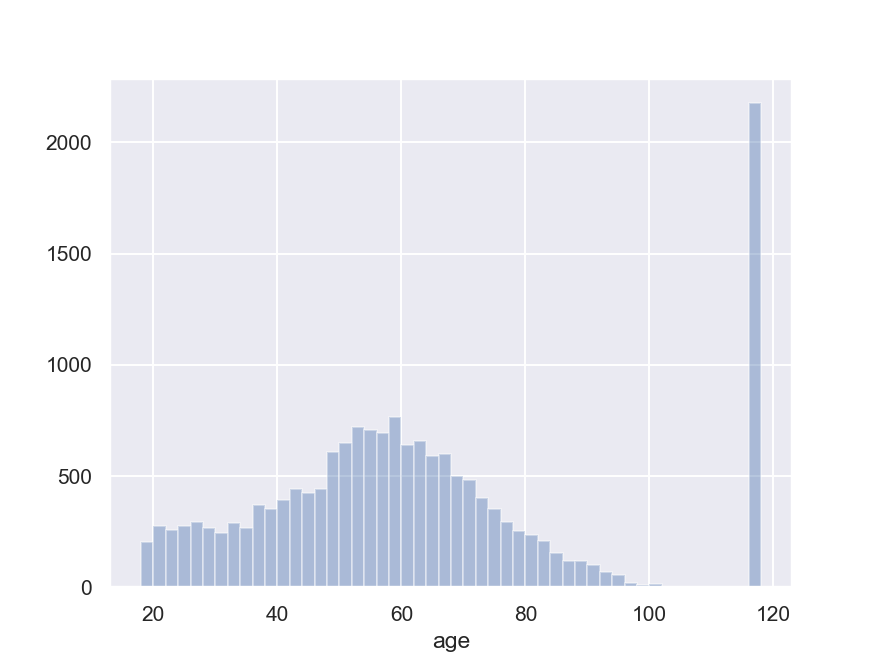

In [78]:
plt.figure()
sns.distplot(profile['age'], bins=50, kde=False);

**Hence, from the above analysis it's clear that people with age 118 are fake entries.**

In [24]:
# check the gender

profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

- There are 8484 males
- There are 6129 feamles
- There are 212 others

## Transcript Dataset¶


In [25]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


- Transcript dataset contain -
<ol>
    <li> Person </li>
    <li> Event </li>
    <li> Value </li>
    <li> Time </li>


</ol>

In [26]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", transcript.shape[0])

Number of row in the dataset are :  306534


In [27]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", transcript.shape[1])

Number of column in the dataset are :  4


In [28]:
# data info

transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [29]:
# check weather there is a null value or not

transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

**There are no null values.**

In [30]:
# describe the dataset

transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [31]:
# datatype of dataframe

transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [32]:
# check the type of events

transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

#  Data Preprocessing

## Profile Dataset

In [33]:
# # how many unique value contain

profile_clean = clean_profile(profile)

In [34]:
profile_clean.head()

,gender,age,customer_id,became_member_on,income,valid,gender_F,gender_M,gender_O
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,0


In [35]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", profile_clean.shape[0])

Number of row in the dataset are :  17000


In [36]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", profile_clean.shape[1])

Number of column in the dataset are :  9


In [37]:
# data info

profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [38]:
# describe the dataset

profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Profile Dataset contain -

- gender
- age
- customer_id
- became_member_on
- income
- age_group
- membership_year
- membership_month 
- membership_day 
- fix the datatype of date 
- Splits the gender column 
- Change the column id to customer_id.
- There are 2,175 NaN values in the gender and income columns

## Portfolio Dataset 

In [39]:
portfolio_clean = clean_portfolio(portfolio)

In [40]:
portfolio_clean.head()

,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [41]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", portfolio_clean.shape[0])

Number of row in the dataset are :  10


In [42]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", portfolio_clean.shape[1])

Number of column in the dataset are :  9


In [43]:
# data info

portfolio_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
reward            10 non-null int64
difficulty        10 non-null int64
duration          10 non-null int64
offer_type        10 non-null object
offer_id          10 non-null object
channel_email     10 non-null uint8
channel_mobile    10 non-null uint8
channel_social    10 non-null uint8
channel_web       10 non-null uint8
dtypes: int64(3), object(2), uint8(4)
memory usage: 568.0+ bytes


In [44]:
# describe the dataset

portfolio_clean.describe()

,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000,1.0,0.900000,0.600000,0.800000
std,3.583915,5.831905,2.321398,0.0,0.316228,0.516398,0.421637
min,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000
25%,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000
50%,4.000000,8.500000,7.000000,1.0,1.000000,1.000000,1.000000
75%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
max,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000


Portfolio Dataset contains - 

- reward            
- difficulty        
- duration          
- offer_type        
- offer_id         
- channel_email     
- channel_mobile   
- channel_social    
- channel_web 
- Splits the channels into several columns
- Split offer_type into several columns
- change id to offer_id

## Transcript Dataset

In [45]:
transcript_clean = clean_transcript(transcript)

In [46]:
transcript_clean.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [47]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", transcript_clean.shape[0])

Number of row in the dataset are :  306534


In [48]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", transcript_clean.shape[1])

Number of column in the dataset are :  8


In [49]:
# describe the dataset

transcript_clean.describe()

,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount
count,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,138953.000000
mean,366.382940,0.109544,0.248837,0.188315,0.453304,12.777356
std,200.326314,0.312321,0.432340,0.390964,0.497815,30.250529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
25%,186.000000,0.000000,0.000000,0.000000,0.000000,2.780000
50%,408.000000,0.000000,0.000000,0.000000,0.000000,8.890000
75%,528.000000,0.000000,0.000000,0.000000,1.000000,18.070000
max,714.000000,1.000000,1.000000,1.000000,1.000000,1062.280000


In [50]:
# data info

transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
customer_id              306534 non-null object
time                     306534 non-null int64
event_offer_completed    306534 non-null uint8
event_offer_received     306534 non-null uint8
event_offer_viewed       306534 non-null uint8
event_transaction        306534 non-null uint8
offer_id                 167581 non-null object
amount                   138953 non-null float64
dtypes: float64(1), int64(1), object(2), uint8(4)
memory usage: 10.5+ MB


Transcript Dataset contain - 

- Customer_id              
- Time                     
- Event_offer_completed    
- Event_offer_received     
- Event_offer_viewed       
- Event_transaction        
- Offer_id               
- Amount        

- Split value in several columns for offers and transactions
- Split event column into sevelar columns
- Change column  person to customer_id

## Combine the Dataframe

In [51]:
df = merge_datasets(portfolio_clean, profile_clean, transcript_clean)

In [52]:
df.describe()

,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,age,income,valid,gender_F,gender_M,gender_O,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web
count,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,138953.000000,306534.000000,272762.000000,306534.000000,306534.000000,306534.000000,306534.000000,167581.00000,167581.000000,167581.000000,167581.0,167581.000000,167581.000000,167581.000000
mean,366.382940,0.109544,0.248837,0.188315,0.453304,12.777356,60.909367,64337.000755,0.889826,0.368967,0.507905,0.012955,4.41991,7.850401,6.610737,1.0,0.917944,0.656996,0.806858
std,200.326314,0.312321,0.432340,0.390964,0.497815,30.250529,26.032030,21243.762941,0.313107,0.482526,0.499938,0.113078,3.37336,5.048944,2.136130,0.0,0.274451,0.474714,0.394765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000
25%,186.000000,0.000000,0.000000,0.000000,0.000000,2.780000,43.000000,48000.000000,1.000000,0.000000,0.000000,0.000000,2.00000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000
50%,408.000000,0.000000,0.000000,0.000000,0.000000,8.890000,57.000000,62000.000000,1.000000,0.000000,1.000000,0.000000,5.00000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
75%,528.000000,0.000000,0.000000,0.000000,1.000000,18.070000,72.000000,78000.000000,1.000000,1.000000,1.000000,0.000000,5.00000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
max,714.000000,1.000000,1.000000,1.000000,1.000000,1062.280000,118.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,10.00000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 24 columns):
customer_id              306534 non-null object
time                     306534 non-null int64
event_offer_completed    306534 non-null uint8
event_offer_received     306534 non-null uint8
event_offer_viewed       306534 non-null uint8
event_transaction        306534 non-null uint8
offer_id                 167581 non-null object
amount                   138953 non-null float64
gender                   272762 non-null object
age                      306534 non-null int64
became_member_on         306534 non-null datetime64[ns]
income                   272762 non-null float64
valid                    306534 non-null int32
gender_F                 306534 non-null uint8
gender_M                 306534 non-null uint8
gender_O                 306534 non-null uint8
reward                   167581 non-null float64
difficulty               167581 non-null float64
duration               

In [54]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", df.shape[0])

Number of row in the dataset are :  306534


In [55]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", df.shape[1])

Number of column in the dataset are :  24


# Exploratory Data Analysis and Data Visualization

Question that I am intrested to answer are -

- What is the population distribution by gender?
- Which are the most popular offer.?
- Which gender group has done the most expensive transaction.?
- What is the relation between income and transaction.?
- The relation between Age and Total expenses.?



##  What are the population distribution by gender.?


In [56]:
customers = per_customer_data(df, profile_clean)

In [57]:
# let see the number of male , women and other

customers.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [58]:
plt.figure(figsize=(10,5))

customers.gender.value_counts().reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, figsize=(10,6), color='tab:red');
plt.ylabel('Number of People');
plt.grid();

<IPython.core.display.Javascript object>

**Clearly, We can see that portion of male are heigher than female and other.**

- Number of Male are 8484

- Number of Female are 6129
- Number of Other are 212


## Which are the most popular offer.?


In [59]:
# Let see which is most popular offer

df[df.event_offer_received == 1].offer_type.value_counts()

discount         30543
bogo             30499
informational    15235
Name: offer_type, dtype: int64

In [60]:
plt.figure(figsize=(10,6))

df[df.event_offer_received == 1].offer_type.value_counts().plot(kind='bar', rot=45, figsize=(10,6), color='tab:green')
plt.title('Offer Type');


<IPython.core.display.Javascript object>

In [61]:
labels=['Discount','Bogo','International']
values=[30543, 30499, 15235]
import matplotlib.pyplot as plt
explode=(0.20,0.20,0)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<IPython.core.display.Javascript object>

We can see that - 
- Discount are most popular offer 30543
- Bogo 30499
- International 15235




##  Which gender group has done most expensive transaction.?


In [62]:
gender_groupby = customers[customers.valid == 1].groupby('gender')


In [63]:
gender_groupby.total_expense.mean()

gender
F    140.919400
M     99.586381
O    124.323302
Name: total_expense, dtype: float64

In [64]:
plt.figure(figsize=(10,6))


gender_groupby.total_expense.mean().reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color='tab:orange');

plt.title('Total Expense');

plt.xlabel('');

plt.grid();
plt.ylabel('Money')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Money')

In [65]:
labels=['Female','Male','Other']
values=[140.919400, 99.586381,124.323302]
import matplotlib.pyplot as plt
explode=(0.20,0.20,0)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<IPython.core.display.Javascript object>

**Female has done most expansive transaction.**

- Female transaction are 140.919400
- Male transaction are 99.586381
- Other transaction are 124.323302


##  What are the relation between income and transaction.?


In [66]:
plt.figure(figsize=(10,6))

income_groupby = customers[(customers.valid == 1) & (customers.income_group > 0)].groupby('income_group')

axis = income_groupby.total_expense.mean().reindex(range(30000, 111000,10000)).plot(kind='line', rot=45, color='tab:red');
plt.title('Total Expense');
plt.xlabel('Income')
plt.ylabel('$')
plt.grid()
axis.set_ylim(0, 200)

<IPython.core.display.Javascript object>

(0, 200)

**As we see transaction increases as the income increases.**

##  Relation between Age and Total expenses.?


In [67]:
plt.figure(figsize=(10,6))

age_groupby = customers[(customers.valid == 1) & (customers.income_group > 0)].groupby('age_group')

ax = age_groupby.total_expense.mean().reindex(range(15, 96,10)).plot(kind='line', rot=0, color='tab:orange');
plt.title('Total Expense');
plt.grid(True);
plt.xlabel('')
plt.xlabel('Age')
plt.ylabel('$')
ax.set_ylim(0, 140)

<IPython.core.display.Javascript object>

(0, 140)

**We can clearly see that income increases as age increases.**

In [69]:
master_df =clean_transcript.merge(clean_portfolio,how='left',on='offer_id')

AttributeError: 'function' object has no attribute 'merge'